In [187]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
from matplotlib.animation import FuncAnimation
import math
import random
from tqdm import tqdm

In [188]:
class MBSimulation:

    def __init__(self, x, v, r, m, R, ballistic):
        '''
        x: initial position of particles
        
        v: initial velocity of particles

        r: radius of particles

        m: mass of particles

        nsteps: number of steps taken in the simulation

        R: radius of the circular tube
        '''
        
        self.x = np.asarray(x, dtype=float)
        self.v = np.asarray(v, dtype=float)
        self.exposure_time = np.zeros(self.x.shape[0])
        self.in_beam = np.zeros(self.x.shape[0])
        self.n = self.x.shape[0]
        self.r = r  # radius of particles
        self.m = m  # mass of particles
        self.nsteps = 0
        self.R = R  # radius of the circular tube
        self.ballistic = ballistic
        self.num_collisions = 0


        for i in range(self.n):
            if np.linalg.norm(self.x[i]) <= self.R:
                self.in_beam[i] = 1
    
        

    def advance(self, dt):
        # Propagate the particles through time
        self.nsteps += 1
        self.x += self.v * dt

        # Keep track of exposure
        for i in range(self.n):
            if np.linalg.norm(self.x[i]) <= self.R:
                self.exposure_time[i] += 1
                self.in_beam[i] = 1
            else:
                self.in_beam[i] = 0
                

        # Get the indices of colliding particles
        dist = squareform(pdist(self.x))
        i_coll, j_coll = np.where(dist < 2 * self.r)
        k = np.where(i_coll < j_coll)
        i_coll, j_coll = i_coll[k], j_coll[k]
        self.num_collisions += len(i_coll)

        if self.ballistic == False:
            # Update the velocities of colliding particles
            for i, j in zip(i_coll, i_coll):
                pos_i, vel_i = self.x[i], self.v[i]
                pos_j, vel_j =  self.x[j], self.v[j]
            
                rel_pos, rel_vel = pos_i - pos_j, vel_i - vel_j
                r_rel = np.dot(rel_pos, rel_pos)
                v_rel = np.dot(rel_vel, rel_pos)
                v_rel = 2 * rel_pos * v_rel / r_rel - rel_vel
                v_cm = (vel_i + vel_j) / 2
                self.v[i] = v_cm - v_rel/2
                self.v[j] = v_cm + v_rel/2

        # # Bounce particles off circular tube
        # for i in range(self.n):
        #     dist_from_origin = np.linalg.norm(self.x[i])
        #     if dist_from_origin + self.r > self.R:
        #         normal = self.x[i] / dist_from_origin
        #         self.v[i] -= 2 * (self.v[i] @ normal) * normal



In [189]:
def MaxwellBoltzmann(v, m, T):
    # Maxwell-Boltzmann distribution
    return np.sqrt(m / (2 * np.pi * T)) ** 3 * 4 * np.pi * v ** 2 * np.exp(-m * v ** 2 / (2 * T))

k_Boltzmann = 1.38064852e-23 # Boltzmann constant

def get_mean_velocity(m, T):
    # Mean velocity of particles
    return np.sqrt(8 * k_Boltzmann * T / (np.pi * m))

In [190]:
def init_pos_vel(R, v_bar, n):

    # Generate n random positions within the beam profile.
    x_list_in = []
    y_list_in = []

    x_list_out = []
    y_list_out = []

    R_around = 3 * R
    for i in range(n):
        # random angle
        alpha = 2 * math.pi * random.random()
        # random radius
        rand_R = R_around * math.sqrt(random.random())
        # calculating coordinates
        x = rand_R * math.cos(alpha)
        y = rand_R * math.sin(alpha)

        if np.linalg.norm([x, y]) > R:
            x_list_out.append(x)
            y_list_out.append(y)

        else:
            x_list_in.append(x)
            y_list_in.append(y)

    pos_in = np.array([x_list_in, y_list_in]).T
    pos_out = np.array([x_list_out, y_list_out]).T




    # Initialize the particles velocities with random orientations and random
    # magnitudes  around the mean speed, sbar.
    theta_in = np.random.random(len(x_list_in)) * 2 * np.pi
    theta_out = np.random.random(len(x_list_out)) * 2 * np.pi
    s0_in = v_bar * np.random.random(len(x_list_in))
    s0_out = v_bar * np.random.random(len(x_list_out))

    vel_in = (s0_in * np.array((np.cos(theta_in), np.sin(theta_in)))).T
    vel_out = (s0_out * np.array((np.cos(theta_out), np.sin(theta_out)))).T

    return pos_in, vel_in, pos_out, vel_out


In [191]:
def get_ensemble_fraction_in_beam(sim_in, sim_out, Time, dt):
    
    avg_exposure_beam_in_list = []
    avg_exposure_beam_out_list = []
    avg_exposure_beam_total_list = []

    for i in tqdm(range(int(Time / dt))):
        avg_exp_in = np.mean(sim_in.exposure_time[np.where(sim_in.in_beam == 1)])
        avg_exposure_beam_in_list.append(avg_exp_in)

        avg_exp_out = np.mean(sim_out.exposure_time[np.where(sim_out.in_beam == 1)])
        if math.isnan(avg_exp_out):
            avg_exp_out = 0
        avg_exposure_beam_out_list.append(avg_exp_out)

        num_beam_in = np.sum(sim_in.in_beam)
        num_beam_out = np.sum(sim_out.in_beam)
        num_beam_total = num_beam_in + num_beam_out
        avg_exposure_beam_total_list.append(num_beam_in/num_beam_total*avg_exp_in + num_beam_out/num_beam_total*avg_exp_out)

        
        sim_in.advance(dt)
        sim_out.advance(dt)
        
    dist_in = np.linalg.norm(sim_in.x, axis=1)
    sum_in = np.sum(dist_in < sim_in.R)

    dist_out = np.linalg.norm(sim_out.x, axis=1)
    sum_out = np.sum(dist_out < sim_out.R)

    # avg_exposure_beam_out_list = []
    # print("Simulating the particles outside the beam")
    # for i in tqdm(range(int(Time / dt))):
    #     avg_exp_out = np.mean(sim_out.exposure_time[np.where(sim_out.in_beam == 1)])
    #     if math.isnan(avg_exp_out):
    #         avg_exp_out = 0
    #     avg_exposure_beam_out_list.append(avg_exp_out)
    #     sim_out.advance(dt)
    
    # dist_out = np.linalg.norm(sim_out.x, axis=1)
    # sum_out = np.sum(dist_out < sim_out.R)
    

    return avg_exposure_beam_in_list, avg_exposure_beam_out_list, avg_exposure_beam_total_list

### Init params and instantiate simulation

In [192]:
# Parameters

# Number of particles.
n = 2000

T = 350  # K
m = 1.44e-25  # kg Rb-87
v_bar = get_mean_velocity(m, T)
print(f"Mean velocity at T = {T} K: {np.round(v_bar)} m/s")

# Time evolution step
dt = 1e-9

# Time necessary for pumping
lifetime = 30e-9
F1_decay_prob = 0.75
n_pump = np.log(0.01)/np.log(F1_decay_prob)
time_pumping = n_pump * lifetime

# Radius of beam
R = 100e-6

# Radius of the particles
r = 20e-8

# Initialize the particles
pos_in, vel_in, pos_out, vel_out = init_pos_vel(R, v_bar, n)

# Initialize the simulation
sim_in = MBSimulation(pos_in, vel_in, r, m, R, True)
sim_out = MBSimulation(pos_out, vel_out, r, m, R, True)


Mean velocity at T = 350 K: 292.0 m/s


### Plot circle with particles

In [193]:
# # Plot positions in a circle
# plt.scatter(sim_in.x[:, 0], sim_in.x[:, 1])
# plt.scatter(sim_out.x[:, 0], sim_out.x[:, 1])
# circle = plt.Circle((0, 0), R, color='r', fill=False)
# plt.gca().add_patch(circle)
# plt.axis('equal')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Particle Positions')
# plt.show()


# # Advance

# print(sim_in.exposure_time[np.where(sim_in.in_beam == 1)])
# print(sim_out.exposure_time[np.where(sim_out.in_beam == 1)])
# sim_in.advance(dt)
# sim_out.advance(dt)

100%|██████████| 480/480 [00:13<00:00, 35.23it/s]


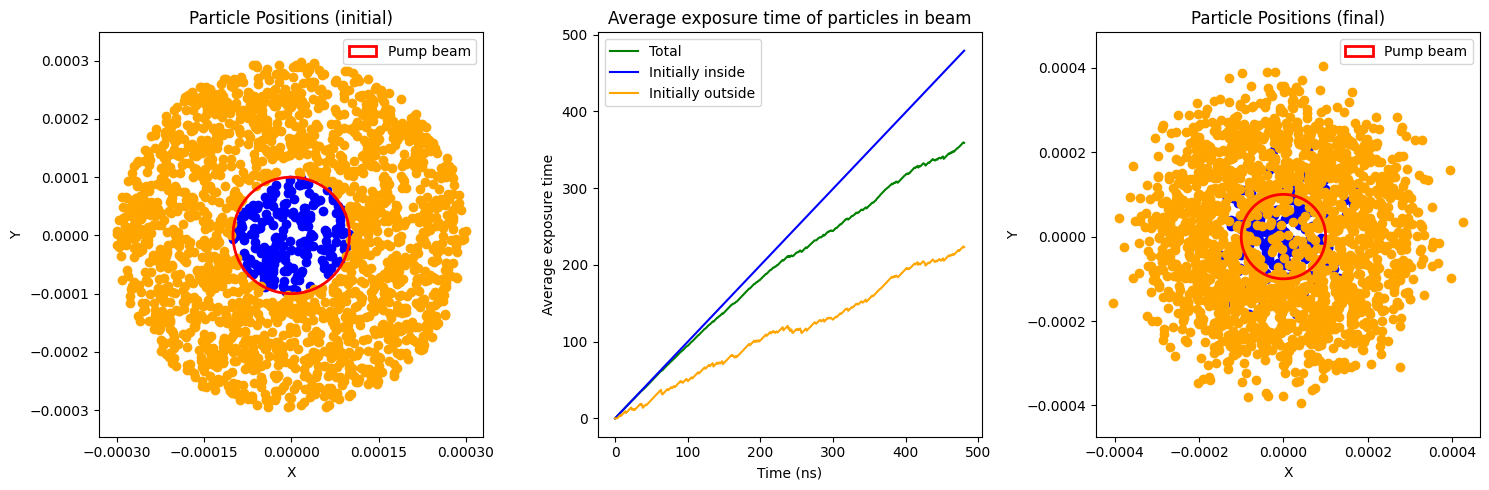

Mean pumped fraction: 0.747296853177167
Remaining fraction in F=1: 0.03201889158538613


In [194]:

fig, ax = plt.subplots(1,3, figsize=(15,5))
# tight_layout() adjusts subplots to fit into figure area.
ax[0].scatter(sim_in.x[:, 0], sim_in.x[:, 1], color='b')
ax[0].scatter(sim_out.x[:, 0], sim_out.x[:, 1], color='orange')
circle = plt.Circle((0, 0), R, color='r', fill=False, lw=2, label='Pump beam')
ax[0].add_artist(circle)
ax[0].axis('equal')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Particle Positions (initial)')
ax[0].legend()
# Change the xticks for ax[0]
ax[0].set_xticks(np.linspace(-3*R, 3*R, 5))

avg_exposure_beam_in_list, avg_exposure_beam_out_list, avg_exposure_beam_total_list = get_ensemble_fraction_in_beam(sim_in, sim_out, time_pumping, dt)
exp_time_array = np.linspace(0, time_pumping, len(avg_exposure_beam_in_list))


ax[1].plot(exp_time_array*1e9, avg_exposure_beam_total_list, label='Total', color='g')
ax[1].plot(exp_time_array*1e9, avg_exposure_beam_in_list, label='Initially inside', color='b')
ax[1].plot(exp_time_array*1e9, avg_exposure_beam_out_list, label='Initially outside', color='orange')
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Average exposure time')
ax[1].legend()
ax[1].set_title('Average exposure time of particles in beam')

ax[2].scatter(sim_in.x[:, 0], sim_in.x[:, 1], color='b')
ax[2].scatter(sim_out.x[:, 0], sim_out.x[:, 1], color='orange')
circle = plt.Circle((0, 0), R, color='r', fill=False, lw=2, label='Pump beam')
ax[2].add_artist(circle)
ax[2].axis('equal')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
ax[2].legend()
ax[2].set_title('Particle Positions (final)')
plt.tight_layout()
plt.show()


# Get mean pumping fraction of atoms
atom_exp_list = np.concatenate((sim_in.exposure_time[np.where(sim_in.in_beam == 1)], sim_out.exposure_time[np.where(sim_out.in_beam == 1)]))

# Define pumping fraction as exposure time devided by necessary pumping time, here 500 ns
pumped_fraction_array = atom_exp_list / time_pumping*1e-9

# Get the mean pumping fraction
mean_pumped_fraction = np.mean(pumped_fraction_array)

# Effective number of pumping cycles
n_pump_eff = mean_pumped_fraction * n_pump

# Estimated remaining fraction in F=1
F1_remaining = F1_decay_prob**n_pump_eff

print(f"Mean pumped fraction: {mean_pumped_fraction}")
print(f"Remaining fraction in F=1: {F1_remaining}")

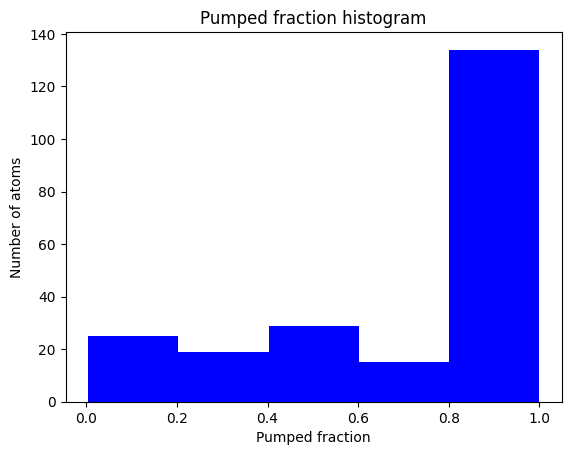

In [199]:
# Create histogram with 20 bins
plt.hist(pumped_fraction_array, bins=5, color='b')
plt.xlabel('Pumped fraction')
plt.ylabel('Number of atoms')
plt.title('Pumped fraction histogram')
plt.show()

In [150]:
# Get average exposure time of atoms in beam after certain time
exposure_beam_in = sim_in.exposure_time[np.where(sim_in.in_beam == 1)]
exposure_beam_out = sim_out.exposure_time[np.where(sim_out.in_beam == 1)]
exposure_list_total = np.concatenate((exposure_beam_in, exposure_beam_out))
t_exp = round(np.mean(exposure_list_total), 1)
print(f"Average exposure time of atoms in the beam: {t_exp} ns")


Average exposure time of atoms in the beam: 398.4 ns


In [ ]:
def get_lifetime(R, frac, r, ballistic):
    # Initialize the simulation
    pos, vel = init_pos_vel(R)
    sim = MBSimulation(pos, vel, r, m, R, ballistic)


    gamma_list = []
    simulation_time = 10000e-9

    # Simulate the particles for a given time.
    for i in range(int(simulation_time / dt)):


        
        dist_from_origin = np.linalg.norm(sim.x, axis=1)
        particles_outside = np.where(dist_from_origin > sim.R)
        N_outside = len(particles_outside[0])
        gamma = N_outside / sim.n

        if gamma > frac:
            break
        
        gamma_list.append(gamma)
        
        
        
        sim.advance(dt)

    # Define lifetime for specific R as the time where frac of the particles are outside the tube
    lifetime = i * dt
    num_collisions = sim.num_collisions

    return lifetime, gamma_list, num_collisions


In [ ]:
R_range = np.linspace(200e-6, 500e-6, 20)
lifetime_list = []
collision_list = []
gamma_list = []
frac = 1- 1/np.exp(1)
r = 2.5e-10

for R in tqdm(R_range):
    lifetime, gamma, num_collisions = get_lifetime(R, frac, r, True)
    lifetime_list.append(lifetime)
    collision_list.append(num_collisions)
    gamma_list.append(gamma)

# Take only non-zero lifetimes
lifetime_list = np.array(lifetime_list)
R_range = R_range[lifetime_list > 0]
lifetime_list = lifetime_list[lifetime_list > 0]

In [ ]:
# Fit linear function to lifetime vs R
m, b = np.polyfit(R_range, lifetime_list, 1)
print(f"Linear fit: y = {m:.2e}x + {b:.2e}")

# Plot linear fit

# Print lifetime for R = 400 um
print(f"Lifetime for R = 400 um: {lifetime_list[np.where(R_range == 400e-6)[0][0]]:.2e} s")

plt.plot(R_range, lifetime_list)
plt.plot(R_range, m * R_range + b)
plt.xlabel('R (m)')
plt.ylabel('Lifetime (s)')
plt.title('Lifetime vs R')
plt.show()


In [ ]:
np.mean(lifetime_list[np.where((R_range < 420e-6)) and np.where((R_range > 380e-6))[0]])

In [ ]:
np.where((R_range < 420e-6)) and np.where((R_range > 380e-6))